# Practice: Statistical Significance

Let's say that we've collected data for a web-based experiment. In the experiment, we're testing the change in layout of a product information page to see if this affects the proportion of people who click on a button to go to the download page. This experiment has been designed to have a cookie-based diversion, and we record two things from each user: which page version they received, and whether or not they accessed the download page during the data recording period. (We aren't keeping track of any other factors in this example, such as number of pageviews, or time between accessing the page and making the download, that might be of further interest.)

Your objective in this notebook is to perform a statistical test on both recorded metrics to see if there is a statistical difference between the two groups.

In [1]:
# import packages

import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats import proportion as proptests

import matplotlib.pyplot as plt
% matplotlib inline

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import data

data = pd.read_csv('data/statistical_significance_data.csv')
data.head(10)

,condition,click
0,1,0
1,0,0
2,0,0
3,1,1
4,1,0
5,1,0
6,0,0
7,1,1
8,0,0
9,1,0


In the dataset, the 'condition' column takes a 0 for the control group, and 1 for the experimental group. The 'click' column takes a values of 0 for no click, and 1 for a click.

## Checking the Invariant Metric

First of all, we should check that the number of visitors assigned to each group is similar. It's important to check the invariant metrics as a prerequisite so that our inferences on the evaluation metrics are founded on solid ground. If we find that the two groups are imbalanced on the invariant metric, then this will require us to look carefully at how the visitors were split so that any sources of bias are accounted for. It's possible that a statistically significant difference in an invariant metric will require us to revise random assignment procedures and re-do data collection.

In this case, we want to do a two-sided hypothesis test on the proportion of visitors assigned to one of our conditions. Choosing the control or the experimental condition doesn't matter: you'll get the same result either way. Feel free to use whatever method you'd like: we'll highlight two main avenues below.

If you want to take a simulation-based approach, you can simulate the number of visitors that would be assigned to each group for the number of total observations, assuming that we have an expected 50/50 split. Do this many times (200 000 repetitions should provide a good speed-variability balance in this case) and then see in how many simulated cases we get as extreme or more extreme a deviation from 50/50 that we actually observed. Don't forget that, since we have a two-sided test, an extreme case also includes values on the opposite side of 50/50. (e.g. Since simulated outcomes of .48 and lower are considered as being more extreme than an actual observation of 0.48, so too will simulated outcomes of .52 and higher.) The proportion of flagged simulation outcomes gives us a p-value on which to assess our observed proportion. We hope to see a larger p-value, insufficient evidence to reject the null hypothesis.

If you want to take an analytic approach, you could use the exact binomial distribution to compute a p-value for the test. The more usual approach, however, is to use the normal distribution approximation. Recall that this is possible thanks to our large sample size and the central limit theorem. To get a precise p-value, you should also perform a 
continuity correction, either adding or subtracting 0.5 to the total count before computing the area underneath the curve. (e.g. If we had 415 / 850 assigned to the control group, then the normal approximation would take the area to the left of $(415 + 0.5) / 850 = 0.489$ and to the right of $(435 - 0.5) / 850 = 0.511$.)

You can check your results by completing the following the workspace and the solution on the following page. You could also try using multiple approaches and seeing if they come up with similar outcomes!

In [3]:
data.condition.value_counts()

1    508
0    491
Name: condition, dtype: int64

Control group has 491 and experiment group has 508 people

In [4]:
data.query('condition == 1')['click'].value_counts()

0    451
1     57
Name: click, dtype: int64

In [5]:
57/451

0.12638580931263857

In the expertiment group, 451 person did not click on the botton, while 57 person did, 12.6% of them did.

In [6]:
data.query('condition == 0')['click'].value_counts()

0    452
1     39
Name: click, dtype: int64

In [7]:
39/452

0.08628318584070796

In the control group, 452 person did not click on the botton, 39 person did, 8,6% of the whole group did.

### Method 1

In [8]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0] # control group

In [13]:
data.groupby('condition').size()[0]

491

In [9]:
# Compute a z-score and p-value
p = 0.5 # P is the probability of the user is control group or experiment group, its a random value, should be 50%
sd = np.sqrt(p * (1-p) * n_obs) # Binomial distribution calculation is p(1-p)/n, sd standar deviation

z = ((n_control + 0.5) - p * n_obs) / sd # z-score is the number of standard deviations from the mean a data point is. 
#z = (x – μ) / σ x= test_score, μ = mean, σ standard deviation, if z score is > 0 it means it is above average, and another way around

print(z)
print(2 * stats.norm.cdf(z))

-0.5062175977346661
0.6127039025537114


### Method 2

In [17]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0]

In [18]:
# # simulate outcomes under null, compare to observed outcome
p = 0.5
n_trials = 200_000

samples = np.random.binomial(n_obs, p, n_trials)

print(np.logical_or(samples <= n_control, samples >= (n_obs - n_control)).mean())

0.61327


## Checking the Evaluation Metric

After performing our checks on the invariant metric, we can move on to performing a hypothesis test on the evaluation metric: the click-through rate. In this case, we want to see that the experimental group has a significantly larger click-through rate than the control group, a one-tailed test.

The simulation approach for this metric isn't too different from the approach for the invariant metric. You'll need the overall click-through rate as the common proportion to draw simulated values from for each group. You may also want to perform more simulations since there's higher variance for this test.

There are a few analytic approaches possible here, but you'll probably make use of the normal approximation again in these cases. In addition to the pooled click-through rate, you'll need a pooled standard deviation in order to compute a z-score. While there is a continuity correction possible in this case as well, it's much more conservative than the p-value that a simulation will usually imply. Computing the z-score and resulting p-value without a continuity correction should be closer to the simulation's outcomes, though slightly more optimistic about there being a statistical difference between groups.

As with the previous question, you'll find a quiz and solution following the workspace for you to check your results.

In [48]:
# your work here: feel free to create additional code cells as needed!
control_click1 = data.query('condition == 0')['click'].mean()
experiment_click1 = data.query('condition == 1')['click'].mean()
differ_converted = experiment_click1 - control_click1

In [49]:
control_click1

0.07942973523421588

In [50]:
experiment_click1

0.11220472440944881

In [51]:
differ_converted

0.03277498917523293

In [59]:
n_exper = data.query('condition == 1').count()[0]
n_new

508

In [60]:
n_control = data.query('condition == 0').count()[0]
n_old

491

In [66]:
# get number of trials and overall 'success' rate under null
p_null = data['click'].mean()
p_null

0.0960960960960961

In [63]:
n_trials = 200_000

ctrl_clicks = np.random.binomial(n_control, p_null, n_trials)
exp_clicks = np.random.binomial(n_exper, p_null, n_trials)
p_diff= exp_clicks - ctrl_clicks

In [65]:
p_diff

array([-10,   3, -14, ...,  -1,   6,   1])

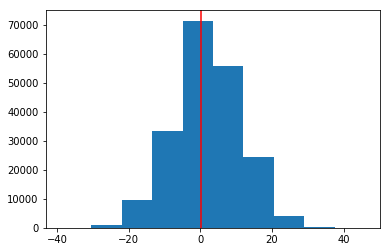

In [75]:
plt.hist(p_diff);
plt.axvline(x=differ_converted, color='red');

In [69]:
samples = exp_clicks / n_exper - ctrl_clicks / n_control
samples

array([-0.02384255,  0.00249771, -0.03103501, ..., -0.00523999,
        0.00915294, -0.00103036])

In [74]:
print((samples >= (differ_converted)).mean())

0.040055


### Method 2

In [52]:
# your work here: feel free to create additional code cells as needed!
control_click = data.query('condition == 0')['click'].sum()
experiment_click = data.query('condition == 1')['click'].sum()
n_control = data.query('condition == 0')['click'].size
n_experiment = data.query('condition == 1')['click'].size

In [53]:
from scipy.stats import norm

z_score, p_value = sm.stats.proportions_ztest( [ experiment_click, control_click ],\
                   [ n_experiment, n_control ], alternative='larger' )
z_score

1.7571887396196666

In [54]:
p_value

0.039442821974613705